In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import msgpack
import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import midi_manipulation


%matplotlib inline

In [3]:
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = []
    for f in tqdm(files):
        try:
            song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
            if np.array(song).shape[0] > 50:
                songs.append(song)
        except Exception as e:
            raise e           
    return songs

In [6]:
songs = get_songs('../../Lab/Pop_Music_Midi/') #These songs have already been converted from midi to msgpack
print "{} songs processed".format(len(songs))

100%|██████████| 126/126 [00:06<00:00, 22.34it/s]

122 songs processed


In [7]:
lowest_note = midi_manipulation.lowerBound #the index of the lowest note on the piano roll
highest_note = midi_manipulation.upperBound #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 15 #This is the number of timesteps that we will create at a time
n_visible      = 2*note_range*num_timesteps #This is the size of the visible layer. 
n_hidden       = 50 #This is the size of the hidden layer

num_epochs = 20000 #The number of training epochs that we are going to run. For each epoch we go through the entire data set.
batch_size = 100 #The number of training examples that we are going to send through the model at a time. 
#lr         = tf.constant(0.005, tf.float32) #The learning rate of our model

In [8]:
x  = tf.placeholder(tf.float32, [None, n_visible], name="x") #The placeholder variable that holds our data
W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") #The weight matrix that stores the edge weights
bh = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="bh")) #The bias vector for the hidden layer
bv = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="bv")) #The bias vector for the visible layer

In [9]:
z_dim = n_hidden #100
X_dim = n_visible #mnist.train.images.shape[1]
h_dim = n_hidden #128


In [10]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [11]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))

In [12]:
def Q(X):
    h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

In [13]:
# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z):
    h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

Iter: 0
Loss: 2.1e+03
Iter: 1000
Loss: 134.6
Iter: 2000
Loss: 116.7
Iter: 3000
Loss: 113.0
Iter: 4000
Loss: 92.73
Iter: 5000
Loss: 83.24
Iter: 6000
Loss: 118.5
Iter: 7000
Loss: 88.52
Iter: 8000
Loss: 97.1
Iter: 9000
Loss: 93.38
Iter: 10000
Loss: 69.78
Iter: 11000
Loss: 100.0
Iter: 12000
Loss: 74.31
Iter: 13000
Loss: 64.18
Iter: 14000
Loss: 67.36
Iter: 15000
Loss: 75.31
Iter: 16000
Loss: 92.66
Iter: 17000
Loss: 68.22
Iter: 18000
Loss: 68.08
Iter: 19000
Loss: 82.34
Iter: 20000
Loss: 88.56


/Users/sdubnov/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


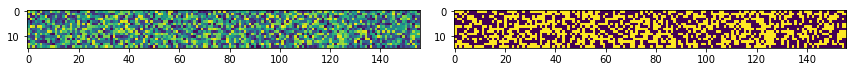

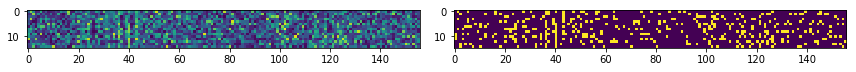

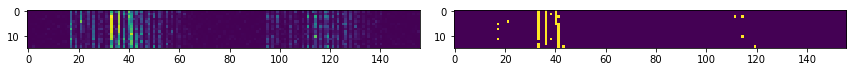

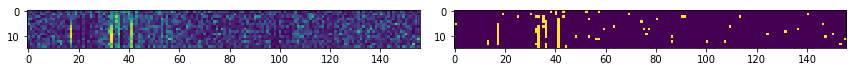

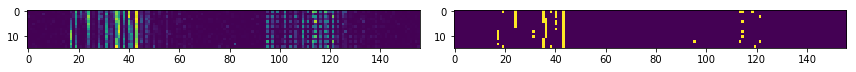

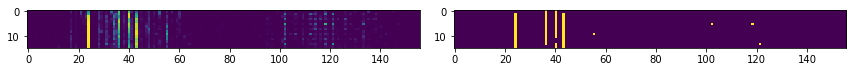

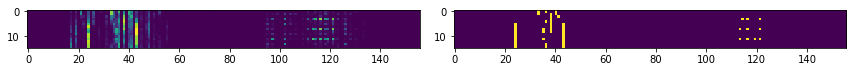

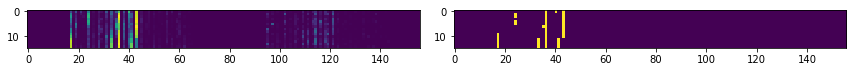

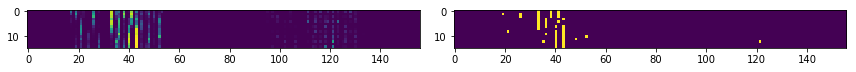

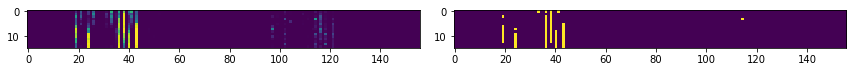

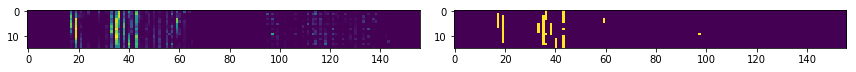

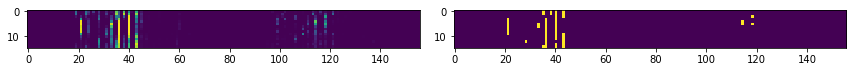

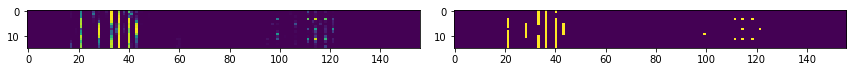

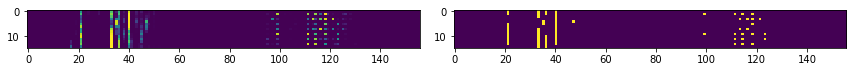

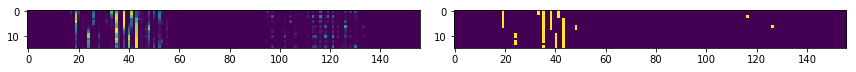

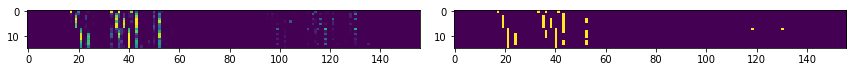

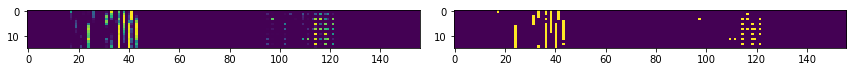

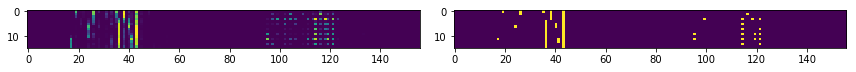

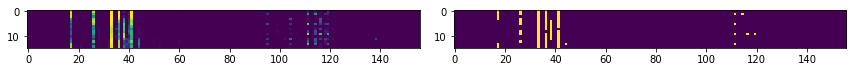

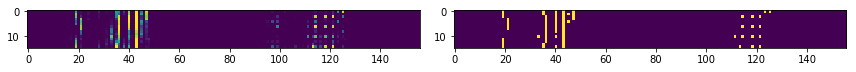

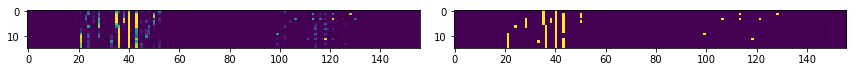

In [14]:
z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss) #check learning rate

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

while i <= num_epochs:
    for song in songs:
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
        song = np.array(song)
        song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
        song = np.reshape(song, [song.shape[0]/num_timesteps, song.shape[1]*num_timesteps])
        # Train the RBM on batch_size examples at a time
        for ind in range(1, len(song), batch_size): 
            X_mb = song[ind:ind+batch_size]
            _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})
    
            if i % 1000 == 0:
                print('Iter: {}'.format(i))
                print('Loss: {:.4}'. format(loss))

                samples = sess.run(X_samples, feed_dict={z: np.random.randn(1,z_dim)})

                S = np.reshape(samples, (num_timesteps, 2*note_range))
                thresh_S = S>=0.5
                plt.figure(figsize=(12,2))
                plt.subplot(1,2,1)
                plt.imshow(S)
                plt.subplot(1,2,2)
                plt.imshow(thresh_S)
                plt.tight_layout()
                plt.pause(0.1)
                midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_{}".format(i))
#                 print(i)
            i += 1
